In [1]:
import sys; sys.path.append('..')
from osp import *

In [2]:
STASH_SLICES_NLP

Config,Param,Value
Path,Root Dir,/Users/ryan/.cache/hashstash/osp_slices_1000_nlp
,Filename,data.db
Engine,Engine,lmdb
,Serializer,hashstash
,Compress,lz4
,B64,True
Stats,Len,21087


In [3]:
BAD_SLICE_FEATS = ['sent_num_punct', 'sent_num_punct_colon', 'sent_num_punct_comma', 'sent_num_parens', 'sent_num_words_verb', 'sent_num_words_noun', 'sent_num_words_adverb', 'sent_num_words_adjective']
BAD_SLICE_FEATS += ['deprel_list','pos_LS','pos_ADD']

def get_slice_feats(id):
    posfeat_counts = STASH_POS_COUNTS.get(id,{})
    deprel_counts = {k:v for k,v in posfeat_counts.items() if k==k.lower()}
    pos_counts = {k:v for k,v in posfeat_counts.items() if k==k.upper()}

    sent_feat_counts = STASH_SENT_FEAT_COUNTS.get(id,{})
    sent_feat_counts_df = pd.DataFrame(sent_feat_counts)

    sent_sums = sent_feat_counts_df.sum(numeric_only=True)
    num_words = sent_sums['num_words']
    num_sents = len(sent_feat_counts)
    sent_sums['num_sents'] = num_sents
    total_clauses = sent_sums['num_independent_clauses'] + sent_sums['num_dependent_clauses']
    out_sent_d = {
        'avg_num_sents': num_sents / num_words * 1000,
        'avg_num_words_per_sent': num_words / num_sents,
        'avg_height': sent_sums['height'] / num_sents,
        'perc_dependent_clauses': sent_sums['num_dependent_clauses'] / total_clauses,
        'perc_independent_clauses': sent_sums['num_independent_clauses'] / total_clauses,
        'avg_num_words_per_clause': num_words / total_clauses,
    }
    out = {
        **{f'sent_{k}':v for k,v in out_sent_d.items()},
        **{f'pos_{k}':v for k,v in pos_counts.items() if k and k[0].isalpha()},
        **{f'deprel_{k}':v for k,v in deprel_counts.items() if k and k[0].isalpha()},
        # **{f'sent_{k}_min':v for k,v in sent_feat_counts_d_min.items()},
        # **{f'sent_{k}_max':v for k,v in sent_feat_counts_d_max.items()}
    }
    return {k:v for k,v in sorted(out.items()) if not any(k.startswith(b) for b in BAD_SLICE_FEATS)}

In [3]:
ids = list(STASH_POS_COUNTS.keys())
idx = ids[1]

In [4]:
# {k:v for k,v in get_slice_feats(idx).items()}

In [5]:
df_meta = get_corpus_metadata()

ids_phil = df_meta[df_meta['discipline'] == 'Philosophy'].index.tolist()
ids_lit = df_meta[df_meta['discipline'] == 'Literature'].index.tolist()

In [6]:
s=df_meta.groupby('journal').decade.nunique().sort_values(ascending=False)
# maxv = s.max()
# s=s[s==maxv]
okv=s.index.tolist()
okv

['The Philosophical Review',
 'Ethics',
 'Modern Philology',
 'The Modern Language Review',
 'PMLA',
 'Proceedings of the Aristotelian Society',
 'Synthese',
 'The Review of English Studies',
 'The Journal of Philosophy',
 'The Review of Metaphysics',
 'ELH',
 'Philosophy and Phenomenological Research',
 'Erkenntnis',
 'Dialectica',
 'Research in Phenomenology',
 'New Literary History',
 'Critical Inquiry',
 'Canadian Journal of Philosophy']

In [7]:
df_meta.query('journal in @okv').journal.value_counts()

journal
Synthese                                    7718
PMLA                                        7258
The Modern Language Review                  5698
The Journal of Philosophy                   4631
Philosophy and Phenomenological Research    3662
Ethics                                      3329
The Review of English Studies               3008
Modern Philology                            2997
The Philosophical Review                    2743
ELH                                         2619
Erkenntnis                                  2515
The Review of Metaphysics                   1958
New Literary History                        1928
Critical Inquiry                            1835
Proceedings of the Aristotelian Society     1745
Dialectica                                  1715
Canadian Journal of Philosophy              1554
Research in Phenomenology                    707
Name: count, dtype: int64

In [8]:
# jrnl_phil = 'The Philosophical Review'
jrnl_phil = 'Synthese'
jrnl_lit = 'PMLA'

In [9]:
def get_valid_feat_keys():
    return set(STASH_POS_COUNTS.keys()) & set(STASH_SENT_FEAT_COUNTS.keys())


def get_feat_counts(ids, desc='getting feat counts'):
    index=[]
    rows=[]
    for idx in tqdm(get_valid_feat_keys(), desc=desc):
        text_id = idx.split('__')[0]
        if idx in ids or text_id in ids:
            index.append(idx)
            rows.append(get_slice_feats(idx))
    odf = pd.DataFrame(rows, index=index).fillna(0).rename_axis('id')
    odf = odf[sorted(odf.columns)]
    return odf

In [10]:
# get_feat_counts(ids_phil[:100])

In [11]:
CLASSIFY_BY_FEAT_SAMPLE_SIZE = 10_000


def classify_by_feat_counts(groups, num_runs=1, sample_size=CLASSIFY_BY_FEAT_SAMPLE_SIZE, incl_deprel=True, incl_pos=True, cv=10,**kwargs):
    name1, ids1 = groups[0]
    name2, ids2 = groups[1]
    df_pos_grp1 = get_feat_counts(ids1)
    df_pos_grp2 = get_feat_counts(ids2)
    min_grp_size = min(len(ids1), len(ids2))
    if sample_size is None:
        sample_size = min_grp_size
    print(f'{name1} {len(ids1)} / {name2} {len(ids2)}')
    l_preds=[]
    l_feats=[]
    iterr = tqdm(list(range(num_runs)))
    for nrun in iterr:
        dfx1=df_pos_grp1.sample(sample_size, replace=True)
        dfx2=df_pos_grp2.sample(sample_size, replace=True)
        df_pos = pd.concat([dfx1, dfx2])
        # df_pos_norm = (df_pos - df_pos.mean()) / df_pos.std()
        # df_pos_norm = df_pos_norm.T
        df_pos_norm = df_pos.copy()
        # for c in df_pos_norm.columns:
            # df_pos_norm[c] = (df_pos_norm[c] - df_pos_norm[c].mean()) / df_pos_norm[c].std()
        
        df_pos_norm['_target'] = [name1] * len(dfx1) + [name2] * len(dfx2)
        iterr.set_description(f'{name1} {len(dfx1)} / {name2} {len(dfx2)}')
        df_preds, df_feats = classify_data(df_pos_norm, target_col='_target', cv=cv, **kwargs)
        l_preds.append(df_preds.assign(run=nrun))
        l_feats.append(df_feats.assign(run=nrun))
    odf_preds = pd.concat(l_preds) if len(l_preds) else None
    odf_feats = pd.concat(l_feats) if len(l_feats) else None

    def _get_mdw_pos(df_feats):
        df_mdw = get_mdw_pos(groups, rename_cols=False).reset_index()
        df_mdw['feat'] = ['deprel_'+x if x==x.lower() else 'pos_'+x for x in df_mdw.feat]
        df_mdw['feat_type'] = [x.split('_')[0] for x in df_mdw.feat]
        df_mdw = df_mdw[~df_mdw.feat.isin(BAD_SLICE_FEATS)]
        df_mdw = df_mdw.set_index('feat').fillna(0).round(1)
        return df_feats.merge(df_mdw, left_on='feature', right_on='feat', how='left')
    return odf_preds, _get_mdw_pos(df_feats)

In [12]:
groups = [
    (jrnl_lit, df_meta.query('journal == @jrnl_lit & year>=2000').index.tolist()),
    (jrnl_phil, df_meta.query('journal == @jrnl_phil & year>=2000').index.tolist()),
]

name1,ids1=groups[0]
name2,ids2=groups[1]

<Axes: ylabel='Frequency'>

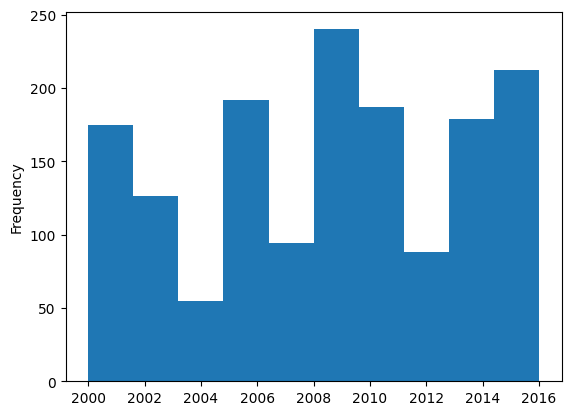

In [13]:
df_meta.loc[ids1].year.plot.hist()

<Axes: ylabel='Frequency'>

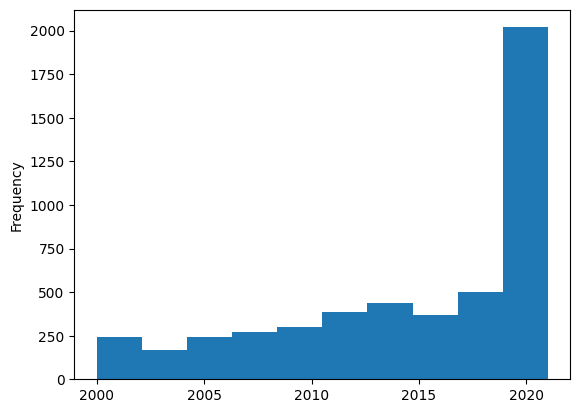

In [14]:
df_meta.loc[ids2].year.plot.hist()

In [15]:
pd.options.display.max_colwidth = 200

In [16]:
df_preds_jrnl, df_feats_jrnl = classify_by_feat_counts(
    groups=groups,
    sample_size=1_000,
    verbose=False,
    num_runs=10,
)
pprint(df_preds_jrnl.accuracy.median() * 100)
feats_jrnl = df_feats_jrnl.groupby('feature').weight.mean().sort_values(ascending=True)
# feats_jrnl.head(25)
df_feats_jrnl

getting feat counts: 100%|██████████| 8756/8756 [00:01<00:00, 5074.77it/s]


PMLA 1548 / Synthese 4936


PMLA 1000 / Synthese 1000: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


np.float64(89.05)


,feature,weight,feat_desc,result_desc,fpk1,fpk2,odds_ratio,sum1,sum2,sig,top1,top2,egs1,egs2,mdw_rank,mdw1_rank,mdw2_rank,feat_type
0,deprel_mark,3.611732,Marker (subordinating conjunction),Marker (subordinating conjunction)s are 1.6x more common in Synthese than PMLA.,29.8,46.9,0.6,4613.0,52028.0,***,to that as of if because by in for while though whether than although since from after without before about so instead on once with whereas until at like re into unless such cause including betwee...,to that if as of in by for whether because since while though although without than about so such from on before whereas once with after like at unless until between instead rather iff upon despit...,"""study, and TO point — by translating"" ""also to note THAT — at least in the"" ""AS I have argued at"" ""as strategies OF creolizing French"" ""the literary, IF it matters at all"" ""instrumental, BECAUSE ...","""I now decide TO press the button"" ""to see to it THAT A, then"" ""probability for IF I now decide to"" ""other hand, AS discussed in the"" ""inevitable consequence OF his making the"" ""is instrumental ...",37.0,81.0,18.0,deprel
1,pos_VB,2.447844,"Verb, base form","Verb, base forms are 1.5x more common in Synthese than PMLA.",26.1,38.1,0.7,4042.0,42297.0,***,be have see print do make say take think write let speak know find understand help go give call read use come mean imagine tell look get live ask suggest die work begin create feel seem consider e...,be have say see make do let consider take explain think suppose know believe show argue provide seem note give understand use call assume go mean get find come require accept apply avoid hold need...,"""Commission may BE better understood"" ""s work may HAVE escaped its due"" ""Poetics; SEE also Chaudhuri"" ""PRINT"" ""something to DO, presumably while"" ""resonances can MAKE us forget how pleasurable"" ""I...","""which we take to BE a sign of irrationality"" ""allowing yourself to HAVE that emotion"" ""would be to SAY that some psychologists"" ""I decide to SEE to it that A"" ""rational) will MAKE an unratifiable...",42.0,77.0,22.0,pos
2,deprel_advmod,2.117407,Adverbial modifier,Adverbial modifiers are 1.3x more common in Synthese than PMLA.,43.9,55.3,0.8,6811.0,61330.0,***,not more also when so even only how then most n't now where just often however thus still here always as never too perhaps indeed less much back well why again instead yet rather especially ever n...,not then only so when also more however even thus how just here where now first n't very still as therefore simply well indeed i.e. why hence at often rather most e.g. merely too of perhaps nt alw...,"""s words here NOT only to point out"" ""is one of the MORE remarkable poets"" ""I ALSO include his allusive"" ""better understood WHEN we exam ine its"" ""once for his SO cial interpretation"" ""literatur...","""the button than NOT to press the button"" ""it that A, THEN"" ""decision will ONLY be made if Paul"" ""psychopath, SO this (alleged"" ""WHEN Paul on the basis"" ""section, he ALSO believes that if"" ""MORE p...",57.0,67.0,32.0,deprel
3,deprel_cop,2.063007,Copula,Copulas are 1.7x more common in Synthese than PMLA.,15.5,25.8,0.6,2400.0,28623.0,***,is are was be were been 's being am 're 'm r re s 'd can ai ys ore con,is are be being was were been 's am s r 'm isnt m 're re thats \ arent = im '( hes does ai will e w } ll do get ]n *{ i( entails ~/( 'd := come have can ma y art has res o |= would,"""author em ploys IS the name of an"" ""literary scholars ARE poets (Glissant"" ""It WAS herself"" ""understood to BE a privi leged site"" ""as though they WERE objects, facing"" ""glad to say, BEEN able to ...","""concludes that it IS pointless to decide"" ""issue of what ARE the identity conditions"" ""beliefs should BE open to rational"" ""compatible with its BEING a natural kind"" ""If it WAS n t the case that""...",34.0,82.0,17.0,deprel
4,pos_VBZ,1.989844,"Verb, 3rd person singular present","Verb, 3rd person

<Axes: ylabel='Frequency'>

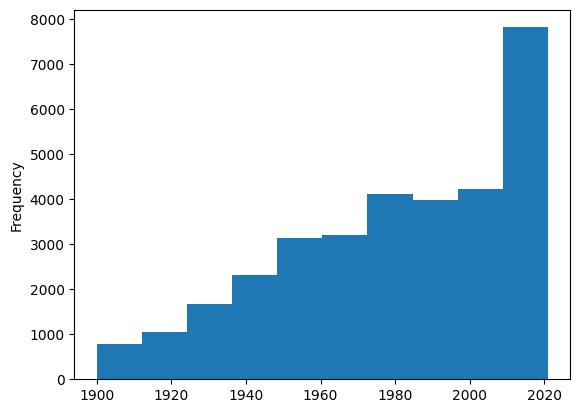

In [135]:
df1=df_meta.query('discipline == "Philosophy"')
df2=df_meta.query('discipline == "Literature"')
df1.year.plot.hist()

<Axes: ylabel='Frequency'>

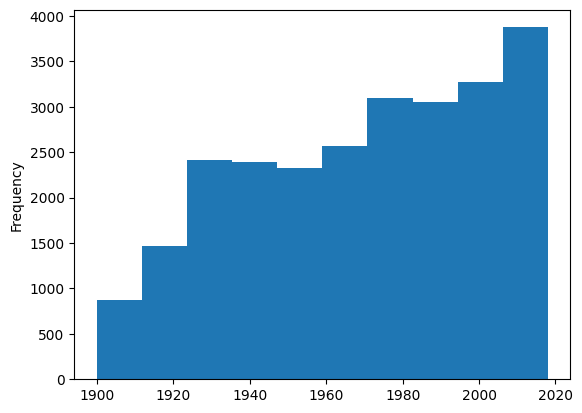

In [136]:
df2.year.plot.hist()

In [137]:
ids_lit0 = df_meta.query('discipline == "Literature"').index.tolist()
ids_phil0 = df_meta.query('discipline == "Philosophy"').index.tolist()
groups = [
    ('Literature', ids_lit0),
    ('Philosophy', ids_phil0),
]

df_preds_jrnl, df_feats_jrnl = classify_by_feat_counts(
    groups=groups,
    sample_size=10_000,
    verbose=False,
    num_runs=10,
)
pprint(df_preds_jrnl.accuracy.median() * 100)
feats_jrnl = df_feats_jrnl.groupby('feature').weight.mean().sort_values(ascending=True)
# feats_jrnl.head(25)
df_feats_jrnl

getting feat counts: 100%|██████████| 8756/8756 [00:09<00:00, 943.36it/s]


Literature 25343 / Philosophy 32277


Literature 10000 / Philosophy 10000: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


np.float64(85.36)


,feature,weight,feat_desc,result_desc,fpk1,fpk2,odds_ratio,sum1,sum2,sig,top1,top2,egs1,egs2,mdw_rank,mdw1_rank,mdw2_rank,feat_type
0,deprel_mark,14.537841,Marker (subordinating conjunction),Marker (subordinating conjunction)s are 1.4x more common in Philosophy than Literature.,32.8,46.7,0.7,96199.0,271937.0,***,to that as if of in for by because while though since than although whether before after so from without with once until whereas on about unless instead at such into till whereby like except rathe...,to that if as of in for because by whether since while though than although without so from about before unless such once whereas on with after until like at between instead except upon into where...,"""permits them TO do so"" ""THAT it is left to right"" ""or the like, AS the event of John"" ""only temporal IF it is a story"" ""regardless OF whether or not"" ""is at first IN order to note"" ""is sufficie...","""are supposed TO be definite abstract"" ""satisfactory merely THAT, at each point"" ""time t. Now IF P(w) is the power"" ""confronts us is AS follows"" ""expect the process OF adding and revising"" ""the cl...",37.0,80.0,19.0,deprel
1,deprel_cop,11.160321,Copula,Copulas are 1.5x more common in Philosophy than Literature.,18.8,27.3,0.7,55191.0,159137.0,***,is are was be were been being am 's 'd 're 'm s tis r re im m ai ist does ys bee art can s't wert 'e 'st t will must doe do doth o wes se le ]n ere con could i' cf. ar gets thats would dost aretwo...,is be are being was were been am 's s r 'm 're m isnt re thats does im can will tis = do \ w ai arent hes 'd get '( e would n has φs { have d o þ must is' ist } ll ®ts (s by »s dis fis are^ aie ds...,"""right, so that IS the way our comic"" ""reconstructions ARE not much different"" ""the mid-nineties WAS indeed representative"" ""answer seems to BE that they do so"" ""because they WERE permanent, by"" ""...","""confronts us IS as follows"" ""are supposed to BE definite abstract"" ""subsets that ARE in the extension"" ""a given set BEING completely determinate"" ""arbitrary subset WAS such that the axiom"" ""conta...",36.0,81.0,18.0,deprel
2,pos_VB,11.030224,"Verb, base form","Verb, base forms are 1.4x more common in Philosophy than Literature.",27.4,38.4,0.7,80171.0,223867.0,***,be have see make say do take find let give know think come seem go understand become show die read speak appear use look write mean suggest tell get consider call explain help bring believe put fe...,be have say do make see let consider know think take suppose show explain believe give seem mean find argue use call understand provide exist accept go come assume get hold follow note require act...,"""as it would BE in literature or"" ""Dodsley would HAVE more ample supplies"" ""title - pages, SEE my description"" ""operationalize — to MAKE verifiably repeatable"" ""define it than to SAY that the wate...","""set theory to BE unending or, at"" ""at least, to HAVE no foreseeable"" ""Let us SAY I faithfully attend"" ""they have to DO"" ""the wise thing MAKE the grade of the"" ""I do not SEE how one can adopt"" ""ph...",40.0,79.0,20.0,pos
3,pos_NNS,8.418525,"Noun, plural","Noun, plurals are 1.2x more common in Philosophy than Literature.",41.5,48.5,0.9,121494.0,282815.0,***,words men terms people others women things years poems works lines forms characters readers texts ways critics ideas writers events means plays times books letters poets children studies images qu...,terms things objects properties cases beliefs reasons conditions others people theories states relations facts words concepts ways propositions laws rules sentences principles events values parts ...,"""descriptions in WORDS, like paintings"" ""were taught by MEN, some but not"" ""between its two TERMS; and the preface"" ""that some PEOPLE die young in order"" ""Where OTHERS see peace, she"" ""These WOM...","""some of the TERMS of his discourse"" ""the kinds of THINGS that strike us"" ""definite abstract OBJECTS, membership in"" ""fo

In [133]:
feats_jrnl

feature
pos_NNP            -5.848159
deprel_case        -2.972049
deprel_punct       -2.769509
deprel_nmod:poss   -2.276230
pos_VBD            -2.114549
                      ...   
pos_NNS             1.625636
deprel_advmod       1.718707
deprel_cop          1.861514
pos_VB              2.358706
deprel_mark         2.873014
Name: weight, Length: 93, dtype: float64

In [134]:
sample_size = 10_000

groups = [
    ('Philosophy', ids_phil),
    ('Literature', ids_lit),
]
df_preds1, df_feats1 = classify_by_feat_counts(groups, cv=10, verbose=False, incl_deprel=True, incl_pos=False, sample_size=sample_size, num_runs=10)
print(df_preds1.accuracy.median() * 100)
df_preds1.groupby('true_label').mean(numeric_only=True)

getting feat counts:  90%|████████▉ | 7850/8756 [00:08<00:00, 977.28it/s] 


KeyboardInterrupt: 

In [151]:
s=df_feats1.groupby('feature').weight.mean().sort_values(ascending=False)
# s

In [152]:
s.sort_values().head(25)

feature
pos_NNP                         -27.750717
deprel_case                     -14.701122
deprel_nmod:poss                -14.580865
pos_VBD                         -12.745885
deprel_conj                     -10.531339
deprel_punct                     -9.639849
pos_PRP$                         -8.352768
deprel_cc                        -6.696947
pos_CC                           -6.286670
pos_POS                          -6.034595
deprel_obl                       -5.044545
deprel_det                       -4.501860
sent_avg_num_words_per_sent      -2.684019
deprel_obj                       -2.621603
deprel_nmod                      -2.314893
pos_VBN                          -2.310985
pos_NNPS                         -2.084605
pos_DT                           -2.033552
deprel_appos                     -2.005748
deprel_parataxis                 -1.821186
sent_avg_num_words_per_clause    -1.324651
deprel_iobj                      -0.683456
deprel_compound:prt              -0.677485
pos

In [153]:
s.sort_values(ascending=False).head(25)

feature
deprel_mark           14.798467
pos_VB                11.246059
deprel_cop            10.915563
pos_NNS                8.777303
pos_VBP                8.245505
pos_MD                 7.860500
pos_JJ                 7.329976
pos_VBZ                6.954873
deprel_aux             5.923943
deprel_ccomp           5.421087
pos_RB                 5.260523
deprel_nsubj           5.226760
deprel_advmod          5.193757
pos_NN                 4.788777
pos_IN                 4.266376
deprel_compound        3.783000
deprel_expl            3.472194
sent_avg_num_sents     2.822631
deprel_acl             2.597503
deprel_root            2.399057
deprel_aux:pass        2.389137
pos_WDT                2.190560
pos_EX                 1.911701
deprel_advcl           1.791028
deprel_nsubj:pass      1.753456
Name: weight, dtype: float64

In [154]:
# df_preds.query('true_label != pred_label').sort_values('confidence', ascending=False)

In [ ]:
# df_preds.query('true_label == pred_label').sort_values('confidence', ascending=False)


In [ ]:
# STASH_SLICES = HashStash('osp_slices_1000')
# pprint(STASH_SLICES['phil/10.2307/20129455']['1'])
# print(STASH_SLICES['phil/10.2307/41681683']['4'])

In [ ]:
ycutoff = 1970
ids1 = df_meta.query(f'discipline == "Philosophy" & 1920<=year<{ycutoff}').index.tolist()
ids2 = df_meta.query(f'discipline == "Philosophy" & {ycutoff}<=year<2020').index.tolist()
sample_size = 10_000

groups = [
    ('Early Philosophy', ids1),
    ('Late Philosophy', ids2),
]

df_preds, df_feats = classify_by_feat_counts(groups, cv=10, verbose=False, incl_deprel=True, incl_pos=True, sample_size=sample_size, num_runs=10)

getting feat counts: 100%|██████████| 8756/8756 [00:06<00:00, 1403.58it/s]


Early Philosophy 10037 / Late Philosophy 18948


Early Philosophy 5000 / Late Philosophy 5000: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


In [ ]:
df_preds.groupby('true_label').mean(numeric_only=True)

,confidence,correct,accuracy,support,run
true_label,,,,,
Early Philosophy,0.552375,0.77764,0.77065,10000.0,4.5
Late Philosophy,0.555091,0.76366,0.77065,10000.0,4.5


In [ ]:
df_feats.groupby('feature').weight.mean().sort_values(ascending=False).head(25)

feature
deprel_compound       9.907630
pos_NNP               5.791630
pos_NNS               5.127038
deprel_obj            5.079990
deprel_mark           4.530929
pos_NN                3.380938
pos_VB                3.367328
deprel_nsubj          3.365902
deprel_amod           3.074274
pos_VBP               2.423153
pos_VBG               2.365652
deprel_ccomp          2.091896
deprel_advmod         1.517934
pos_POS               1.483890
deprel_acl            1.439484
deprel_root           1.409840
pos_VBZ               1.403969
sent_avg_num_sents    1.378393
pos_HYPH              1.292864
deprel_advcl          1.262884
pos_RB                1.232901
pos_WRB               0.711158
pos_MD                0.695215
pos_TO                0.677249
deprel_appos          0.676106
Name: weight, dtype: float64

In [ ]:
df_feats.groupby('feature').weight.mean().sort_values(ascending=True).head(25)

feature
deprel_conj                     -8.589953
pos_CC                          -8.418333
deprel_cc                       -7.972222
deprel_case                     -5.731456
pos_DT                          -4.149808
deprel_det                      -4.039147
pos_PRP                         -3.739997
pos_IN                          -3.726512
deprel_nmod                     -3.486911
pos_VBD                         -3.057097
pos_VBN                         -3.043287
deprel_punct                    -2.734405
deprel_aux:pass                 -1.987708
deprel_obl                      -1.934682
pos_PRP$                        -1.631322
deprel_nsubj:pass               -1.401981
sent_avg_num_words_per_sent     -1.355336
pos_WDT                         -0.546554
deprel_cop                      -0.470353
sent_avg_num_words_per_clause   -0.376544
deprel_nmod:poss                -0.345758
deprel_obl:agent                -0.294613
pos_WP                          -0.289556
pos_PDT                   

In [ ]:
ids1 = df_meta.query(f'discipline == "Literature" & 1920<=year<{ycutoff}').index.tolist()
ids2 = df_meta.query(f'discipline == "Literature" & {ycutoff}<=year<2020').index.tolist()

groups = [
    ('Early Literature', ids1),
    ('Late Literature', ids2),
]

df_preds2, df_feats2 = classify_by_feat_counts(groups, cv=10, verbose=False, incl_deprel=True, incl_pos=True, sample_size=sample_size, num_runs=10)
df_preds2.groupby('true_label').mean(numeric_only=True)

getting feat counts: 100%|██████████| 8756/8756 [00:03<00:00, 2513.11it/s]


Early Literature 9944 / Late Literature 13527


Early Literature 5000 / Late Literature 5000: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


,confidence,correct,accuracy,support,run
true_label,,,,,
Early Literature,0.559166,0.68548,0.70776,10000.0,4.5
Late Literature,0.559769,0.73004,0.70776,10000.0,4.5


In [ ]:
df_feats2.groupby('feature').weight.mean().sort_values(ascending=False).head(10)

feature
pos_NN                         12.174633
deprel_amod                     7.567758
pos_JJ                          6.058391
deprel_compound                 4.190907
pos_NNS                         3.800391
pos_VBZ                         3.377723
sent_avg_num_words_per_sent     2.456888
pos_VBG                         2.401416
deprel_obj                      2.381759
deprel_acl:relcl                2.176104
Name: weight, dtype: float64

In [ ]:
df_feats2.groupby('feature').weight.mean().sort_values(ascending=True).head(10)

feature
pos_NNP              -8.021148
pos_VBD              -5.227477
pos_PRP              -3.757405
deprel_root          -2.983147
sent_avg_num_sents   -2.809758
deprel_aux           -2.754666
pos_VBN              -2.664854
pos_DT               -2.529525
pos_PRP$             -2.232843
deprel_det           -1.998085
Name: weight, dtype: float64

In [ ]:
df_preds1.accuracy.median() * 100, df_preds.accuracy.median() * 100, df_preds2.accuracy.median() * 100

(np.float64(85.345),
 np.float64(76.92999999999999),
 np.float64(70.71000000000001))